In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
sys.path.append('../core/')
from scipy.interpolate import splev, splrep, RegularGridInterpolator
from matplotlib.lines import Line2D
from copy import deepcopy
from tools import *
from settings import *

In [3]:
colors = [
    (0.24423453, 0.20678459, 0.41985299),
    (0.20692679, 0.48201774, 0.63812656),
    (0.29215894, 0.76144162, 0.67886578),
    (0.953125, 0.59765625, 0.02734375)
]

In [4]:
# define location of experiments
poles = {
    'IceCube': {"lon": 1*u.deg, "lat": -90*u.deg, "color": "tab:orange"},
    'Gen-2': {"lon": 1*u.deg, "lat": -90*u.deg, "color": "magenta"},
    'P-ONE': {"lon": -123.3656*u.deg, "lat": 48.4284*u.deg, "color": "tab:blue"},
    'KM3NeT': {"lon": (16 + 6/60)*u.deg, "lat": (36 + 16/60)*u.deg, "color": "k"},
    'Baikal-GVD': {"lon": 108.1650*u.deg, "lat": 53.5587*u.deg, "color": "tab:cyan"},
    'Plenum': {"color": "darkred"}
}

### Get all detection efficiencies (calculated in point_source_discovery_time_evolution.ipynb)

In [5]:
with open("../resources/detection_efficiencies.pckl", "rb") as f:
    det_eff, padded_sd = pickle.load(f) # spline and original sindec values

### Get the current values for sens and disc pot

In [6]:
ps_disc = dict()
ind_disc = dict()
xsd = dict()
ic_10yr = dict()
spl_10yr = dict()


gamma = 2.0
ps_disc[gamma] = np.genfromtxt('../resources/tcarver_10y_disc.csv', delimiter=',')
ind_disc[gamma] = np.argsort(ps_disc[gamma][:,0])
xsd[gamma] = ps_disc[gamma][:,0][ind_disc[gamma] ]
ic_10yr[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ]
spl_10yr[gamma] = splrep(xsd[gamma], ic_10yr[gamma])


gamma = 2.5
ps_disc[gamma] = np.genfromtxt('../resources/10yr_ps_dicPot_g25_tessaThesis.csv', delimiter=',')
ind_disc[gamma] = np.argsort(ps_disc[gamma][:,0])
xsd[gamma] = ps_disc[gamma][:,0][ind_disc[gamma] ]
ic_10yr[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ]
spl_10yr[gamma] = splrep(xsd[gamma], ic_10yr[gamma])

gamma = 3.0
ps_disc[gamma] = np.genfromtxt('../resources/10yr_ps_dicPot_g3_tessaThesis.csv', delimiter=',')
ind_disc[gamma] = np.argsort(ps_disc[gamma][:,0])
xsd[gamma] = ps_disc[gamma][:,0][ind_disc[gamma] ]
ic_10yr[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ]
spl_10yr[gamma] = splrep(xsd[gamma], ic_10yr[gamma])

ps_sens = dict()
ind_sens = dict()
xsd_sens = dict()
ic_10yr_sens = dict()
spl_10yr_sens = dict()

gamma = 2.0
ps_sens[gamma] = np.genfromtxt('../resources/sens_10yr_gamma-2.txt', delimiter=' ')
ind_sens[gamma] = np.argsort(ps_sens[gamma][:,0])
xsd_sens[gamma] = ps_sens[gamma][:,0][ind_sens[gamma] ]
ic_10yr_sens[gamma] = ps_sens[gamma][:,1][ind_sens[gamma] ]
spl_10yr_sens[gamma] = splrep(xsd_sens[gamma], ic_10yr_sens[gamma])
gamma = 3.0
ps_sens[gamma] = np.genfromtxt('../resources/sens_10yr_gamma-3.txt', delimiter=' ')
ind_sens[gamma] = np.argsort(ps_sens[gamma][:,0])
xsd_sens[gamma] = ps_sens[gamma][:,0][ind_sens[gamma] ]
ic_10yr_sens[gamma] = ps_sens[gamma][:,1][ind_sens[gamma] ]
spl_10yr_sens[gamma] = splrep(xsd_sens[gamma], ic_10yr_sens[gamma])

### ALL the performance :)

In [7]:
sns.set_palette("viridis")

In [8]:
disc = np.genfromtxt('../resources/PSdiscPot7years.csv', delimiter=',')
sdec = disc[:,0]
disc = disc[:,1]
tck_disc = splrep(sdec, np.log(disc), s=1.e-3)
xvals = np.linspace(-1, 1, 1000)
spl_disc = splev(xvals, tck_disc)

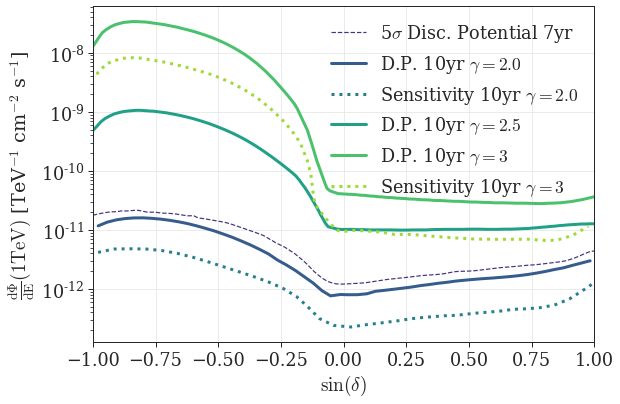

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(xvals, np.exp(spl_disc), ls='dashed', label="5$\sigma$ Disc. Potential 7yr")
for gamma in [2.0, 2.5, 3]:
    ax.plot(xsd[gamma], ic_10yr[gamma], lw=3, label=rf'D.P. 10yr $\gamma={gamma}$')
    if gamma!=2.5: ax.plot(xsd_sens[gamma], ic_10yr_sens[gamma], lw=3, label=rf'Sensitivity 10yr $\gamma={gamma}$', ls=":")
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$\frac{\rm d\Phi}{\rm dE}(1{\rm TeV})$ [TeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
ax.legend(
    loc='upper right',
    ncol=1, frameon=False,# bbox_to_anchor=(1.28, 0.5)
)
fig.tight_layout()

# Catalogs

## LHAASO
Flux at 100 TeV x CU, with flux unit `CU` $= 6.1 \cdot  10^{−17}$ photons / TeV cm² s

Flux conversion from arXiv:2105.09851v1

$\Phi_\gamma^{UL}(100 TeV) = 0.5 \cdot \Phi_{\nu_\mu + \bar{\nu}_\mu}^{UL}(E_\nu) \left(\frac{50 TeV}{E_\nu} \right)^{-\gamma}$

In [10]:
CU = 6.1E-17 # photons / TeV cm^2 s == Crab Unit
lhaaso = pd.read_csv("../resources/LHAASO.txt", delimiter="\t", skipinitialspace=True, comment="#")

In [11]:
### add limits from IC searches as in arXiv:2105.09851v1 available in #10yr IC
# limits at 1 TeV: phi ~ phi_0 * (E/1 TeV) ^ (-gamma)
lhaaso["nu limit E-2"] = 0.0
lhaaso["nu limit E-3"] = 0.0 
lhaaso["nu counterpart"] = "none"

lhaaso["nu counterpart"].loc[lhaaso.source=="LHAASO J0534+2202"] = "Crab Nebula" # ---- SED available
lhaaso["nu limit E-2"].loc[lhaaso.source=="LHAASO J0534+2202"] = 3.7 * 1E-13
lhaaso["nu limit E-3"].loc[lhaaso.source=="LHAASO J0534+2202"] = 0.76 * 1E-11

lhaaso["nu counterpart"].loc[lhaaso.source=="LHAASO J1825-1326"] = "HESS J1826-130"
lhaaso["nu limit E-2"].loc[lhaaso.source=="LHAASO J1825-1326"] = 13 * 1E-13

lhaaso["nu counterpart"].loc[lhaaso.source=="LHAASO J1839-0545"] = "HESS J1841-055"
lhaaso["nu limit E-2"].loc[lhaaso.source=="LHAASO J1839-0545"] = 4.8 * 1E-13
lhaaso["nu limit E-3"].loc[lhaaso.source=="LHAASO J1839-0545"] = 3.28 * 1E-11

lhaaso["nu counterpart"].loc[lhaaso.source=="LHAASO J1843-0338"] = "HESS J1843-033"
lhaaso["nu limit E-2"].loc[lhaaso.source=="LHAASO J1843-0338"] = 2.5 * 1E-13
lhaaso["nu limit E-3"].loc[lhaaso.source=="LHAASO J1843-0338"] = 1.09 * 1E-11

lhaaso["nu counterpart"].loc[lhaaso.source=="LHAASO J1849-0003"] = "HESS J1849-000"
lhaaso["nu limit E-2"].loc[lhaaso.source=="LHAASO J1849-0003"] = 2.2 * 1E-13
lhaaso["nu limit E-3"].loc[lhaaso.source=="LHAASO J1849-0003"] = 1.01 * 1E-11

lhaaso["nu counterpart"].loc[lhaaso.source=="LHAASO J1908+0621"] = "MGRO J1908+06"  # ---- SED available
lhaaso["nu limit E-2"].loc[lhaaso.source=="LHAASO J1908+0621"] = 5.7 * 1E-13
lhaaso["nu limit E-3"].loc[lhaaso.source=="LHAASO J1908+0621"] = 2.11 * 1E-11

lhaaso["nu counterpart"].loc[lhaaso.source=="LHAASO J2018+3651"] = "MGRO J2019+37"
lhaaso["nu limit E-2"].loc[lhaaso.source=="LHAASO J2018+3651"] = 4.0 * 1E-13
lhaaso["nu limit E-3"].loc[lhaaso.source=="LHAASO J2018+3651"] = 0.69 * 1E-11

lhaaso["nu counterpart"].loc[lhaaso.source=="LHAASO J2032+4102"] = "2HWC J2031+415" ### possibly Cygnus OB2
lhaaso["nu limit E-2"].loc[lhaaso.source=="LHAASO J2032+4102"] = 9.2 * 1E-13
lhaaso["nu limit E-3"].loc[lhaaso.source=="LHAASO J2032+4102"] = 1.41 * 1E-11

In [14]:
lhaaso

,source,ra,dec,significance,Emax,Emax_uncertainty_minus,Emax_uncertainty_plus,Flux,Flux_uncertainty,nu limit E-2,nu limit E-3,nu counterpart
0,LHAASO J0534+2202,83.55,22.05,17.8,0.88,0.11,0.11,1.00,0.14,3.700000e-13,7.600000e-12,Crab Nebula
1,LHAASO J1825-1326,276.45,-13.45,16.4,0.42,0.16,0.16,3.57,0.52,1.300000e-12,0.000000e+00,HESS J1826-130
2,LHAASO J1839-0545,279.95,-5.75,7.7,0.21,0.05,0.05,0.70,0.18,4.800000e-13,3.280000e-11,HESS J1841-055
3,LHAASO J1843-0338,280.75,-3.65,8.5,0.26,0.10,0.16,0.73,0.17,2.500000e-13,1.090000e-11,HESS J1843-033
4,LHAASO J1849-0003,282.35,-0.05,10.4,0.35,0.07,0.07,0.74,0.15,2.200000e-13,1.010000e-11,HESS J1849-000
5,LHAASO J1908+0621,287.05,6.35,17.2,0.44,0.05,0.05,1.36,0.18,5.700000e-13,2.110000e-11,MGRO J1908+06
6,LHAASO J1929+1745,292.25,17.75,7.4,0.71,0.07,0.16,0.38,0.09,0.000000e+00,0.000000e+00,none
7,LHAASO J1956+2845,299.05,28.75,7.4,0.42,0.03,0.03,0.41,0.09,0.000000e+00,0.000000e+00,none
8,LHAASO J2018+3651,304.75,36.85,10.4,0.27,0.02,0.02,0.50,0.10,4.000000e-13,6.900000e-12,MGRO J2019+37
9,LHAASO J2032+4102,308.05,41.05,10.5,1.42,0.13,0.13,0.54,0.10,9.200000e-13,1.410000e-11,2HWC J2031+415


## SED data

In [15]:
from scipy.optimize import curve_fit

def log_parabola(phi0, E, a, b):
    return phi0 * (E/1E13) ** (-a - b*np.log10(E/1E13))

def log_parabola_E2(phi0, E, a, b):
    return log_parabola(phi0, E, a, b) * E**2

def powerlaw(phi0, E, gamma):
    return phi0 * (E/1E13) ** -gamma

def powerlaw_E2(phi0, E, gamma):
    return powerlaw(phi0, E, gamma) * E**2

In [16]:
crab = np.array([
    # energy/TeV, dN/dE / TeV^-1 cm^-2 s^-1
    [12.6 * 1E12, 4.52E-14, 0.04E-14, 0.04E-14],
    [20.0 * 1E12, 1.13E-14, 0.09E-14, 0.09E-14],
    [31.6 * 1E12, 2.98E-15, 0.24E-15, 0.24E-15],
    [50.1 * 1E12, 6.64E-16, 0.78E-16, 0.78E-16],
    [79.4 * 1E12, 1.43E-16, 0.23E-16, 0.23E-16],
    [126  * 1E12, 4.05E-17, 0.91E-17, 0.91E-17],
    [200  * 1E12, 8.00E-18, 3.8E-18, 3.2E-18]
])

crab = pd.DataFrame(crab, columns=["E", "flux", "flux_err_plus", "flux_err_minus"])

crab["source"] = "LHAASO J0534+2202"
# translate to E^2 /erg
crab.flux = crab.flux * (crab.E/1E12)**2 * 1.602
crab.flux_err_minus = crab.flux_err_minus * (crab.E/1E12)**2 * 1.602
crab.flux_err_plus = crab.flux_err_plus * (crab.E/1E12)**2 * 1.602

crab["E_err_minus"] = crab.E - 10**np.arange(1, 2.3, step=0.2) *1E12
crab["E_err_plus"] = 10**np.arange(1.2, 2.5, step=0.2) *1E12 -  crab.E


j2226 = pd.read_csv("../resources/J2228_KM2A_201209.dat", delimiter=" ", skipinitialspace=True, comment="#")
j2226["source"] = "LHAASO J2226+6057"
j1825 = pd.read_csv("../resources/J1825_KM2A_201209.dat", delimiter=" ", skipinitialspace=True, comment="#")
j1825["source"] = "LHAASO J1825-1326"
j1908 = pd.read_csv("../resources/J1908_KM2A_201209.dat", delimiter=" ", skipinitialspace=True, comment="#")
j1908["source"] = "LHAASO J1908+0621"
lhaaso_sed = pd.concat([j2226, j1825, j1908, crab], ignore_index=True)

lhaaso_sed["E_err_avg"] = (lhaaso_sed.E_err_minus + lhaaso_sed.E_err_plus) / 2
lhaaso_sed["flux_err_avg"] = (lhaaso_sed.flux_err_minus + lhaaso_sed.flux_err_plus) / 2

## add fit parameters
lhaaso_sed["a"] = 0
lhaaso_sed["b"] = 0
lhaaso_sed["G"] = 0
lhaaso_sed["phi0_LP"] = 0
lhaaso_sed["phi0_Pow"] = 0

lhaaso_sed["G"].loc[lhaaso_sed.source=="LHAASO J0534+2202"] = 3.09
lhaaso_sed["phi0_Pow"].loc[lhaaso_sed.source=="LHAASO J0534+2202"] = 1.13E-14 * 2**3.09 * 1.602 * 1E-24 # translate norm. to erg

lhaaso_sed["a"].loc[lhaaso_sed.source=="LHAASO J2226+6057"] = 1.56
lhaaso_sed["b"].loc[lhaaso_sed.source=="LHAASO J2226+6057"] = 0.88
lhaaso_sed["G"].loc[lhaaso_sed.source=="LHAASO J2226+6057"] = 3.01


lhaaso_sed["a"].loc[lhaaso_sed.source=="LHAASO J1908+0621"] = 2.27
lhaaso_sed["b"].loc[lhaaso_sed.source=="LHAASO J1908+0621"] = 0.46
lhaaso_sed["G"].loc[lhaaso_sed.source=="LHAASO J1908+0621"] = 2.89


lhaaso_sed["a"].loc[lhaaso_sed.source=="LHAASO J1825-1326"] = 0.92
lhaaso_sed["b"].loc[lhaaso_sed.source=="LHAASO J1825-1326"] = 1.19
lhaaso_sed["G"].loc[lhaaso_sed.source=="LHAASO J1825-1326"] = 3.36

In [17]:
gcm = plt.get_cmap('plasma_r')
nu_colors = [gcm(th/5) for th in range(5)][1:]

Limit conversion step.by.step:
* $E^2 \frac{d\Phi_\gamma}{dE}$ = $\rm  \Phi_\nu^0(UL) \cdot \frac{1}{2} \cdot (50 TeV / 1 TeV)^{-\gamma}  \cdot (100 TeV/1 TeV)^2 \cdot (E_\nu/100 TeV)^{-\gamma+2}$
* Gamma Limit ($\frac{d\Phi_\gamma}{dE}$) normalized at 100 TeV
* Original neutrino limit ($\rm  \Phi_\nu^0(UL)$) normalized at 1 TeV -> extrapolated to 50 TeV

### with neutrino limits from source catalogs

### with neutrino limits just from generic 'declination limits'

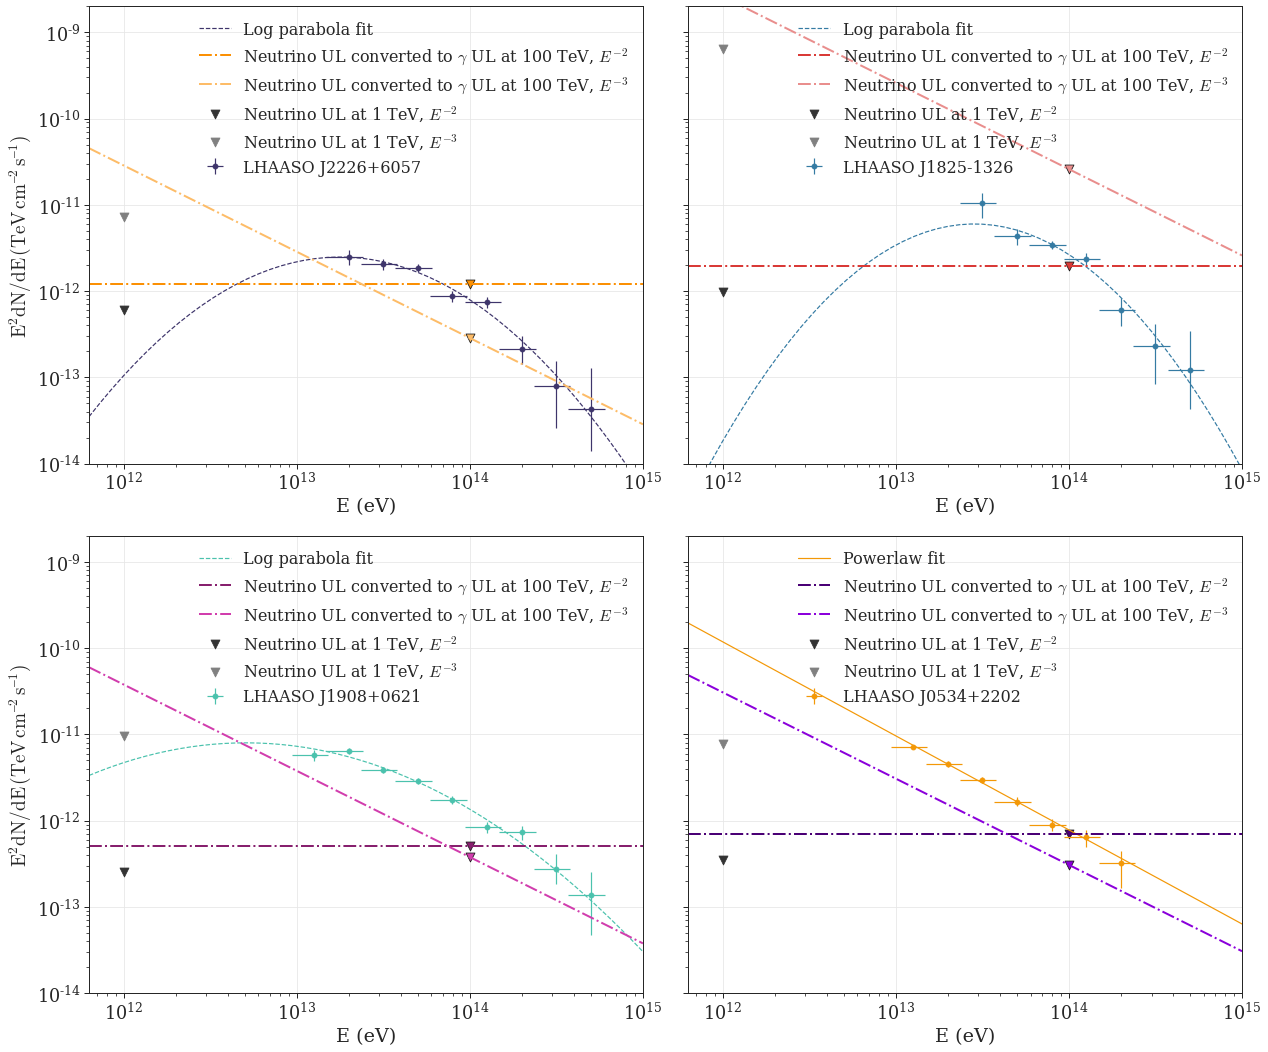

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 15), sharey=True, sharex=False)
xe = np.logspace(11.8, 15)

TeV = True # TeV or erg on y axis = flux units
factor = 1.602 if TeV else 1.
    
for i, src in enumerate(lhaaso_sed.source.unique()):
    ax = axes.flatten()[i]
    p = ax.errorbar(
        lhaaso_sed.loc[lhaaso_sed.source==src].E,
        lhaaso_sed.loc[lhaaso_sed.source==src].flux / factor,
        yerr=[lhaaso_sed.loc[lhaaso_sed.source==src].flux_err_plus / factor, lhaaso_sed.loc[lhaaso_sed.source==src].flux_err_minus / factor],
        xerr=[lhaaso_sed.loc[lhaaso_sed.source==src].E_err_plus, lhaaso_sed.loc[lhaaso_sed.source==src].E_err_minus],
        fmt="o",# lw=0,
        color=colors[i],
        label=src
    )
    a = lhaaso_sed["a"].loc[lhaaso_sed.source==src].unique()[0]
    b = lhaaso_sed["b"].loc[lhaaso_sed.source==src].unique()[0]
    gamma = lhaaso_sed["G"].loc[lhaaso_sed.source==src].unique()[0]
    
    # log parabola
    if not src=="LHAASO J0534+2202":
        p0 = lhaaso_sed.loc[lhaaso_sed.source==src].flux.iloc[0] / lhaaso_sed.loc[lhaaso_sed.source==src].E.iloc[0]**2 / factor
        popt, pcov = curve_fit(
            lambda x, p: log_parabola_E2(p, x, a, b),
            lhaaso_sed.loc[lhaaso_sed.source==src].E,
            lhaaso_sed.loc[lhaaso_sed.source==src].flux / factor,
            sigma=lhaaso_sed.loc[lhaaso_sed.source==src].flux_err_avg,
            p0=[p0]
        )
        lhaaso_sed["phi0_LP"].loc[lhaaso_sed.source==src] = popt[0]
        ax.plot(
            xe, log_parabola_E2(popt[0], xe, a, b),# / factor,
            color=p[0].get_color(),
            ls="--", label="Log parabola fit"
        )
    else:
        # CRAB power-law fit
        ax.plot(
            xe, powerlaw_E2(lhaaso_sed["phi0_Pow"].loc[lhaaso_sed.source==src].unique()[0], xe, gamma) / factor,
            color=p[0].get_color(),
            ls="-", label="Powerlaw fit"
        )
    
    #### Neutrinos #####
    gamma = 2
    ### E-2
    value = splev(np.sin(np.deg2rad(lhaaso["dec"].loc[lhaaso.source==src])), spl_10yr_sens[gamma])[0]
    ax.scatter(
        1E12, value * 1.602 / factor, 
        color="0.2", marker="v", s=80, label=r"Neutrino UL at 1 TeV, $E^{-2}$")
    #ax.plot(
    #    xe, value * 1.602 / factor * (xe/1E12)**(-2+2),
    #    color="0.2", ls="--", lw=1, label=r"Neutrino limit $E^{-2}$")
    ax.scatter(
        1E14, value * 1.602 / factor * 50**(-2) / 2 * (1E14/1E12)**2, # gamma limit
        color=change_color_ld(nu_colors[i], -0.1), marker="v", s=80, edgecolor="k")
    ax.plot(
        xe, value * 1.602 / factor * 50**(-2) / 2 * (1E14/1E12)**2 * (xe/1E14)**(-2+2), # gamma limit
        color=change_color_ld(nu_colors[i], -0.1), ls="-.", lw=2, label=r"Neutrino UL converted to $\gamma$ UL at 100 TeV, $E^{-2}$")    
    
    gamma = 3
    ### E-3
    value = splev(np.sin(np.deg2rad(lhaaso["dec"].loc[lhaaso.source==src])), spl_10yr_sens[gamma])[0]
    ax.scatter(
        1E12, value * 1.602 / factor,
        color="0.5", marker="v", s=80, label=r"Neutrino UL at 1 TeV, $E^{-3}$")
    #ax.plot(
    #    xe, value * 1.602 / factor * (xe/1E12)**(-3+2),
    #    color="0.5", ls="--", lw=1, label=r"Neutrino limit $E^{-3}$")
    ax.scatter(
        1E14, value * 1.602 / factor * 50**(-3) / 2 * (1E14/1E12)**2, # gamma limit
        color=change_color_ld(nu_colors[i], +0.1), marker="v", s=80, edgecolor="k")
    ax.plot(
        xe, value * 1.602 / factor * 50**(-3) / 2 * (1E14/1E12)**2 * (xe/1E14)**(-3+2), # gamma limit
        color=change_color_ld(nu_colors[i], +0.1), ls="-.", lw=2, label=r"Neutrino UL converted to $\gamma$ UL at 100 TeV, $E^{-3}$")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlim(10**11.8, 1E15)
    ax.set_ylim(1E-14, 2E-9)
    ax.set_xlabel("E (eV)")
    ax.legend(loc='upper right', ncol=1, frameon=False, fontsize="small")
axes[0][0].set_ylabel(r"$\rm E^2 dN/dE \, ({} \,  cm^{{–2}} \,  s^{{–1}})$".format("TeV" if TeV else "erg"))
axes[1][0].set_ylabel(r"$\rm E^2 dN/dE \, ({} \,  cm^{{–2}} \,  s^{{–1}})$".format("TeV" if TeV else "erg"))

fig.tight_layout()

## scale to Plenum

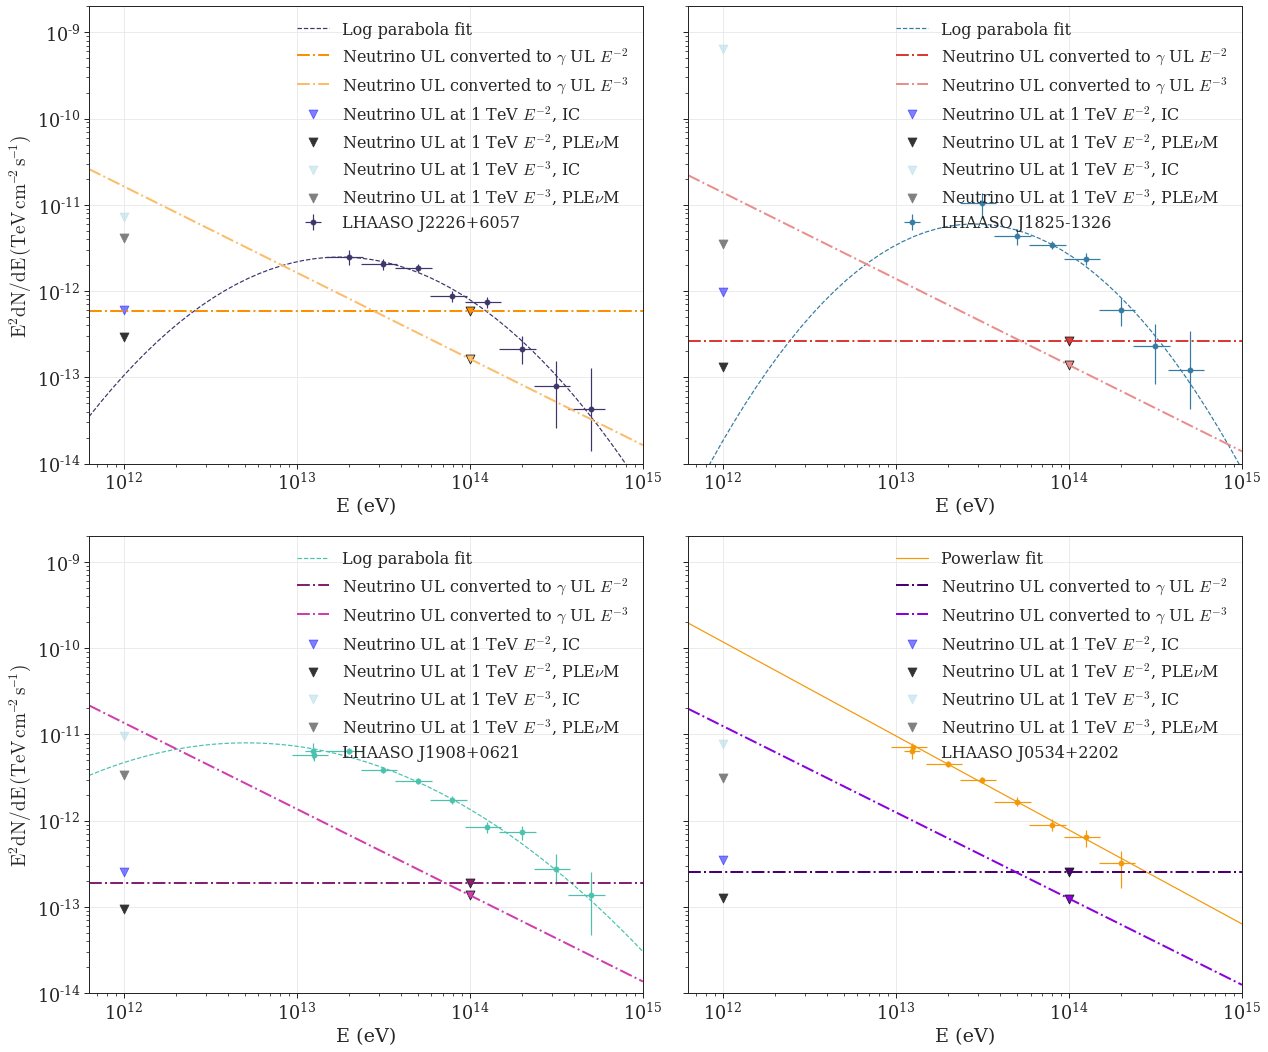

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 15), sharey=True, sharex=False)
xe = np.logspace(11.8, 15)

TeV = True # TeV or erg on y axis = flux units
factor = 1.602 if TeV else 1.
    
for i, src in enumerate(lhaaso_sed.source.unique()):
    ax = axes.flatten()[i]
    p = ax.errorbar(
        lhaaso_sed.loc[lhaaso_sed.source==src].E,
        lhaaso_sed.loc[lhaaso_sed.source==src].flux / factor,
        yerr=[lhaaso_sed.loc[lhaaso_sed.source==src].flux_err_plus / factor, lhaaso_sed.loc[lhaaso_sed.source==src].flux_err_minus / factor],
        xerr=[lhaaso_sed.loc[lhaaso_sed.source==src].E_err_plus, lhaaso_sed.loc[lhaaso_sed.source==src].E_err_minus],
        fmt="o",# lw=0,
        color=colors[i],
        label=src
    )
    a = lhaaso_sed["a"].loc[lhaaso_sed.source==src].unique()[0]
    b = lhaaso_sed["b"].loc[lhaaso_sed.source==src].unique()[0]
    gamma = lhaaso_sed["G"].loc[lhaaso_sed.source==src].unique()[0]
    
    # log parabola
    if not src=="LHAASO J0534+2202":
        p0 = lhaaso_sed.loc[lhaaso_sed.source==src].flux.iloc[0] / lhaaso_sed.loc[lhaaso_sed.source==src].E.iloc[0]**2 / factor
        popt, pcov = curve_fit(
            lambda x, p: log_parabola_E2(p, x, a, b),
            lhaaso_sed.loc[lhaaso_sed.source==src].E,
            lhaaso_sed.loc[lhaaso_sed.source==src].flux / factor,
            sigma=lhaaso_sed.loc[lhaaso_sed.source==src].flux_err_avg,
            p0=[p0]
        )
        lhaaso_sed["phi0_LP"].loc[lhaaso_sed.source==src] = popt[0]
        ax.plot(
            xe, log_parabola_E2(popt[0], xe, a, b),# / factor,
            color=p[0].get_color(),
            ls="--", label="Log parabola fit"
        )
    else:
        # CRAB power-law fit
        ax.plot(
            xe, powerlaw_E2(lhaaso_sed["phi0_Pow"].loc[lhaaso_sed.source==src].unique()[0], xe, gamma) / factor,
            color=p[0].get_color(),
            ls="-", label="Powerlaw fit"
        )
    
    #### Neutrinos #####
    gamma = 2
    ### E-2
    sd_val = np.sin(np.deg2rad(lhaaso["dec"].loc[lhaaso.source==src]))
    value = splev(sd_val, spl_10yr_sens[gamma])[0]    
    
    ax.scatter(
        1E12, value * 1.602 / factor, 
        color="blue", marker="v", s=80, label=r"Neutrino UL at 1 TeV $E^{-2}$, IC", alpha=0.5)
    
    ### Scale with Plenum detection efficiency
    plenum = value * np.exp((det_eff[gamma]["IceCube"](sd_val) - det_eff[gamma]["Plenum"](sd_val))* 0.8)
    # 10 yr icecube, then 10yr plenum with icecube
    value = (value ** (-1/0.8) + plenum ** (-1/0.8)) ** -0.8
    
    ax.scatter(
        1E12, value * 1.602 / factor, 
        color="0.2", marker="v", s=80, label=r"Neutrino UL at 1 TeV $E^{-2}$, PLE$\nu$M")
    ax.scatter(
        1E14, value * 1.602 / factor * 50**(-2) / 2 * (1E14/1E12)**2, # gamma limit
        color=change_color_ld(nu_colors[i], -0.1), marker="v", s=80, edgecolor="k")
    ax.plot(
        xe, value * 1.602 / factor * 50**(-2) / 2 * (1E14/1E12)**2 * (xe/1E14)**(-2+2), # gamma limit
        color=change_color_ld(nu_colors[i], -0.1), ls="-.", lw=2, label=r"Neutrino UL converted to $\gamma$ UL $E^{-2}$")    
    
    gamma = 3
    ### E-3
    value = splev(sd_val, spl_10yr_sens[gamma])[0]    
    
    ax.scatter(
        1E12, value * 1.602 / factor,
        color="lightblue", marker="v", s=80, label=r"Neutrino UL at 1 TeV $E^{-3}$, IC", alpha=0.5)
    
    ### Scale with Plenum detection efficiency
    plenum = value * np.exp((det_eff[gamma]["IceCube"](sd_val) - det_eff[gamma]["Plenum"](sd_val))* 0.8)
    # 10 yr icecube, then 10yr plenum with icecube
    value = (value ** (-1/0.8) + plenum ** (-1/0.8)) ** -0.8
    
    ax.scatter(
        1E12, value * 1.602 / factor,
        color="0.5", marker="v", s=80, label=r"Neutrino UL at 1 TeV $E^{-3}$, PLE$\nu$M")
    ax.scatter(
        1E14, value * 1.602 / factor * 50**(-3) / 2 * (1E14/1E12)**2, # gamma limit
        color=change_color_ld(nu_colors[i], +0.1), marker="v", s=80, edgecolor="k")
    ax.plot(
        xe, value * 1.602 / factor * 50**(-3) / 2 * (1E14/1E12)**2 * (xe/1E14)**(-3+2), # gamma limit
        color=change_color_ld(nu_colors[i], +0.1), ls="-.", lw=2, label=r"Neutrino UL converted to $\gamma$ UL $E^{-3}$")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlim(10**11.8, 1E15)
    ax.set_ylim(1E-14, 2E-9)
    ax.set_xlabel("E (eV)")
    ax.legend(loc='upper right', ncol=1, frameon=False, fontsize="small")
axes[0][0].set_ylabel(r"$\rm E^2 dN/dE \, ({} \,  cm^{{–2}} \,  s^{{–1}})$".format("TeV" if TeV else "erg"))
axes[1][0].set_ylabel(r"$\rm E^2 dN/dE \, ({} \,  cm^{{–2}} \,  s^{{–1}})$".format("TeV" if TeV else "erg"))

fig.tight_layout()

## Estimate sensitive energy range via event numbers

In [20]:
# use only upgoing data to mimick up-going muon track data set
with open("../resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_2d = pickle.load(f)

log_emids = calc_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = calc_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = calc_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi*2, num=361)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
50 declination bins


In [21]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), 
    np.log(flux_def['numu_conv'])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

In [22]:
reset_palette(3, "mako")

### variant 1) central 90% range of signal events

IceCube
Plenum


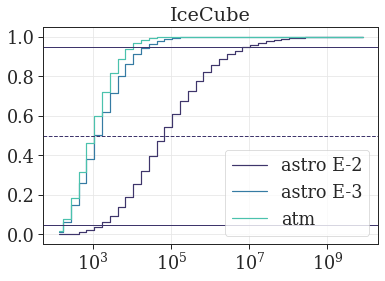

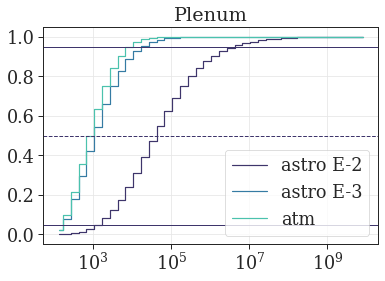

In [23]:
src_sindec = np.sin(np.deg2rad(0))
idx = np.where(sindec_bins > src_sindec)[0][0] - 1
for det in ["IceCube", "Plenum"]:
    f, ax = plt.subplots()
    aeff_factor = aeff_2d[det][:,idx] * ewidth * LIVETIME
    astro_ev_2 = aeff_factor * (emids/1E3)**(-2) * 1E-15
    astro_ev_3 = aeff_factor * (emids/1E3)**(-3) * 1E-15
    atm_ev = aeff_factor * spl_vals[idx] * sindec_width[idx]
    print(det)
    ax.plot(emids, np.cumsum(astro_ev_2)/np.sum(astro_ev_2), drawstyle="steps-mid", label="astro E-2")
    ax.plot(emids, np.cumsum(astro_ev_3)/np.sum(astro_ev_3), drawstyle="steps-mid", label="astro E-3")
    ax.plot(emids, np.cumsum(atm_ev)/np.sum(atm_ev), drawstyle="steps-mid", label="atm")
    ax.axhline(0.5, lw=1, ls="--")
    ax.axhline(0.05, lw=1)
    ax.axhline(0.95, lw=1)
    ax.set_xscale("log")
    ax.set_title(det)
    ax.legend()

### variant 2) sqrt(signal / background) weighting

#### weighted cumulative sum?

IceCube
Plenum


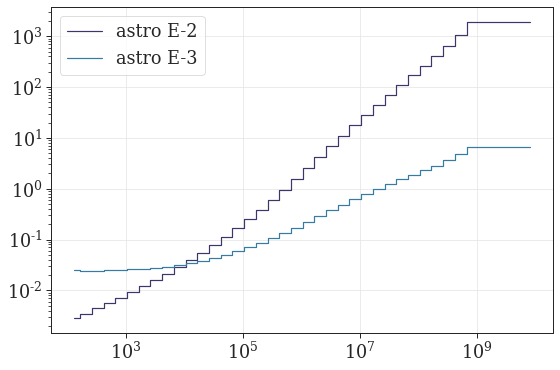

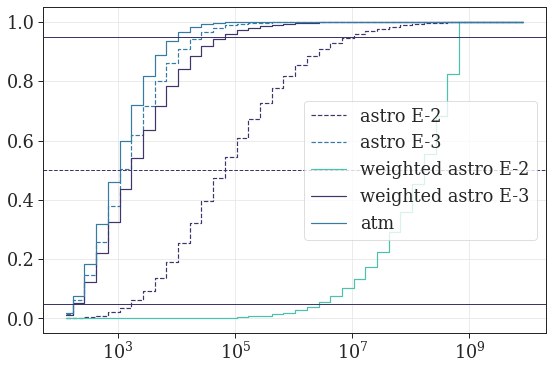

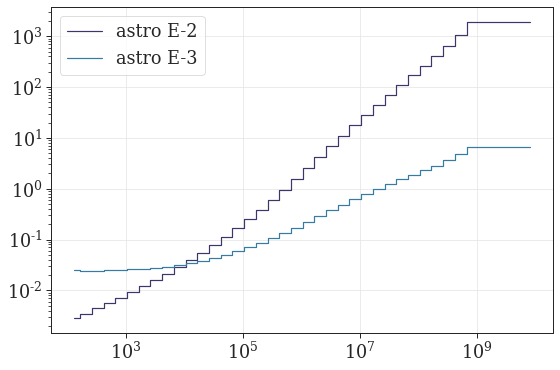

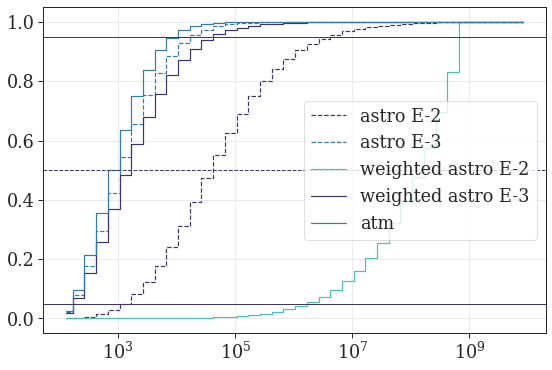

In [24]:
src_sindec = np.sin(np.deg2rad(0))
idx = np.where(sindec_bins > src_sindec)[0][0] - 1
for det in ["IceCube", "Plenum"]:
    
    aeff_factor = aeff_2d[det][:,idx] * ewidth * LIVETIME
    astro_ev_2 = aeff_factor * (emids/1E3)**(-2) * 1E-15
    astro_ev_3 = aeff_factor * (emids/1E3)**(-3) * 1E-14
    atm_ev = aeff_factor * spl_vals[idx] * sindec_width[idx] * 5
    print(det)
    w_2 = np.zeros_like(atm_ev)
    w_3 = np.zeros_like(atm_ev)
    mask = atm_ev > 0 
    w_2[mask] = astro_ev_2[mask]/atm_ev[mask]
    w_2[~mask] = np.max(w_2)
    w_3[mask] = astro_ev_3[mask]/atm_ev[mask]
    w_3[~mask] = np.max(w_3)
    f, ax = plt.subplots(figsize=(9, 6))
    ax.plot(emids, np.sqrt(w_2), drawstyle="steps-mid", label="astro E-2")
    ax.plot(emids, np.sqrt(w_3), drawstyle="steps-mid", label="astro E-3")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend()
    
    f, ax = plt.subplots(figsize=(9, 6))
    weighted_cs_2 = np.cumsum(astro_ev_2 * np.sqrt(w_2))
    weighted_cs_2 /= weighted_cs_2[-1]
    weighted_cs_3 = np.cumsum(astro_ev_3 * np.sqrt(w_3))
    weighted_cs_3 /= weighted_cs_3[-1]
    ax.plot(emids, np.cumsum(astro_ev_2)/np.sum(astro_ev_2), drawstyle="steps-mid", label="astro E-2", ls="--")
    ax.plot(emids, np.cumsum(astro_ev_3)/np.sum(astro_ev_3), drawstyle="steps-mid", label="astro E-3", ls="--")
    ax.plot(emids, weighted_cs_2, drawstyle="steps-mid", label="weighted astro E-2")
    ax.plot(emids, weighted_cs_3, drawstyle="steps-mid", label="weighted astro E-3")
    ax.plot(emids, np.cumsum(atm_ev)/np.sum(atm_ev), drawstyle="steps-mid", label="atm")
    ax.axhline(0.5, lw=1, ls="--")
    ax.axhline(0.05, lw=1)
    ax.axhline(0.95, lw=1)
    ax.set_xscale("log")
    ax.legend()

# energy range is difficult to define properly without the original analysis information!

# Scale to PLEnuM

### Idea:
* Discovery potential improvement for same time -> translated from scaling in effective area

$R = \frac{\Phi_0}{\Phi_{\rm new}} = \left( \frac{t_0}{t_{\rm new}} \right)^{-0.8} = \left( \frac{t_{\rm new}}{t_0} \right)^{0.8} = \left( \frac{\int dE \cdot A_{\rm eff, new} \cdot d\Phi/dE}{\int dE A_{\rm eff, 0} \cdot d\Phi/dE} \right)^{0.8} \equiv \left( \frac{\epsilon_{\rm new}}{\epsilon_{\rm IC}} \right)^{0.8}$

$\Rightarrow \Phi_{\rm new} = \frac{\Phi_{IC}}{R} = \Phi_{IC} \cdot \left( \frac{\epsilon_{\rm IC}}{\epsilon_{\rm new}} \right)^{0.8}$ (with detection efficiency = $\epsilon$)

* ALternative: adding known discovery potentials via
$ \Phi_{add} = \Phi_0 \oplus \Phi_1  := \left( \Phi_0^{-1/0.8} + \Phi_1^{-1/0.8} \right)^{-0.8} $

NameError: name 'cgen' is not defined

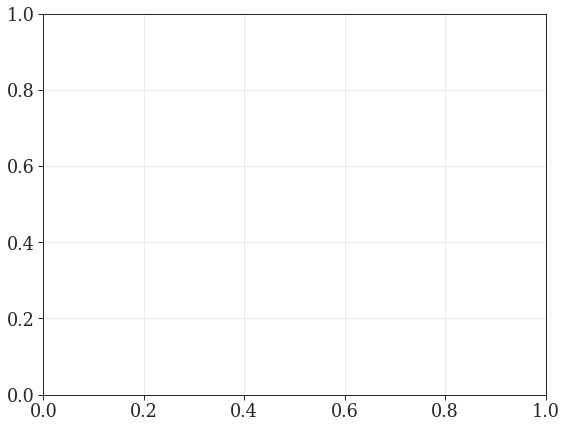

In [25]:
gamma= 2.0

ic_20yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
# gen2 10yr
gen2 = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Gen-2"](xsd[gamma]))* 0.8)
# plenum 10yr
plenum = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum"](xsd[gamma]))* 0.8)
# 10 yr icecube, then 10yr plenum with icecube
ic_plenum = (ic_10yr[gamma] ** (-1/0.8) + plenum ** (-1/0.8)) ** -0.8
# 10 yr icecube, then 10yr plenum with gen2 (instead of plenum with icecube only)
ic_plenum_gen2 = (plenum ** (-1/0.8) + gen2 ** (-1/0.8)) ** -0.8

# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 10**(-2*gamma) / 1.e3

f, ax = plt.subplots(figsize=(9, 7))

ax.plot(
    xsd[gamma], ic_10yr[gamma] * const,
    color=cgen[0],
    lw=3, label=r'IceCube (10yr)')
ax.plot(
    xsd[gamma], ic_20yr * const,
    color=cgen[1],
    lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd[gamma], ic_plenum * const,
    color=cgen[2], ls="--",
    lw=3, label=r'10yr IceCube + 10yr PLE$\nu$M')
ax.plot(
    xsd[gamma], ic_plenum_gen2 * const,
    color=cgen[2],
    lw=3, label=r'10yr IceCube + PLE$\nu$M with Gen-2 (10yr)')

ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$E^2 \cdot \frac{\rm d\Phi}{\rm dE}$ [TeV cm$^{-2}$ s$^{-1}$]')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
f.legend( 
    loc='upper center', mode='expand',
    ncol=2, frameon=False
)
ax.text(0.75,0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize=22 ,
         transform = ax.transAxes)

ax.set_ylabel(r"$\phi^{\mathrm{thr}}_{100\mathrm{TeV}}$  [$\mathrm{GeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1}$]")

ax.tick_params(axis='both', which='major')
ax.set_ylim(5e-21, 1.5e-17) 
# add the location of the galactic center and TXS
ax.annotate("Galactic Center", xy=(np.sin(np.radians(-29.)), 5.e-21), xytext=(np.sin(np.radians(-50.)), 15.e-21),
        arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)

ax.annotate("TXS 0506+056", xy=(np.sin(np.radians(5.7)), 5.e-21), xytext=(np.sin(np.radians(25.7)), 8.e-21),
        arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)
f.tight_layout()
plt.subplots_adjust(top = 0.85)

In [ ]:
gamma= 3
# conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
const = 10**(-2*gamma) / 1.e3


ic_20yr = ps_disc[gamma][:,1][ind_disc[gamma] ] * (0.5 ** 0.8) # double time from 10yr baseline to 20yr
# gen2 10yr
gen2 = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Gen-2"](xsd[gamma]))* 0.8)
# plenum 10yr
plenum = ps_disc[gamma][:,1][ind_disc[gamma] ] \
    * np.exp((det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum"](xsd[gamma]))* 0.8)
# 10 yr icecube, then 10yr plenum with icecube
ic_plenum = (ic_10yr[gamma] ** (-1/0.8) + plenum ** (-1/0.8)) ** -0.8
# 10 yr icecube, then 10yr plenum with gen2 (instead of plenum with icecube only)
ic_plenum_gen2 = (plenum ** (-1/0.8) + gen2 ** (-1/0.8)) ** -0.8


f, ax = plt.subplots(figsize=(9, 7))

ax.plot(
    xsd[gamma], ic_10yr[gamma] * const,
    color=cgen[0],
    lw=3, label=r'IceCube (10yr)')

ax.plot(
    xsd[gamma], ic_20yr * const,
    color=cgen[1],
    lw=3, label=r'IceCube (20yr)')
ax.plot(
    xsd[gamma], ic_plenum * const,
    color=cgen[2], ls="--",
    lw=3, label=r'10yr IceCube + 10yr PLE$\nu$M')
ax.plot(
    xsd[gamma], ic_plenum_gen2 * const,
    color=cgen[2],
    lw=3, label=r'10yr IceCube + PLE$\nu$M with Gen-2 (10yr)')

ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$E^2 \cdot \frac{\rm d\Phi}{\rm dE}$ [TeV cm$^{-2}$ s$^{-1}$]')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
f.legend( 
    loc='upper center', mode='expand',
    ncol=2, frameon=False
)
ax.text(0.75,0.8, r'$\gamma={0:.1f}$'.format(gamma), fontsize=22 ,
         transform = ax.transAxes)
ax.set_ylabel(r"$\phi^{\mathrm{thr}}_{100\mathrm{TeV}}$  [$\mathrm{GeV}^{-1} \mathrm{cm}^{-2} \mathrm{s}^{-1}$]")
ax.tick_params(axis='both', which='major')
#ax.set_ylim(5e-21, 1.5e-17) 
# add the location of the galactic center and TXS
#ax.annotate("Galactic Center", xy=(np.sin(np.radians(-29.)), 5.e-21), xytext=(np.sin(np.radians(-50.)), 15.e-21),
#        arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)
#
#ax.annotate("TXS 0506+056", xy=(np.sin(np.radians(5.7)), 5.e-21), xytext=(np.sin(np.radians(25.7)), 8.e-21),
#        arrowprops=dict(arrowstyle="-|>", color="k"), fontsize=12)
f.tight_layout()
plt.subplots_adjust(top = 0.85)